# Multi-sample tissue compartment detection

## 1. Integrate samples with Scanorama

In [2]:
import scanorama
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import chrysalis as ch

We begin by loading the anterior and posterior mouse brain samples. We proceed by removing the low-quality capture spots and genes that are expressed in fewer than 10 spots and appending samples to the `adatas` list. We then run `scanorama` using the dedicated `scanpy` function to correct the expression matrices.

In [3]:
samples = ['V1_Mouse_Brain_Sagittal_Anterior_Section_2', 'V1_Mouse_Brain_Sagittal_Posterior_Section_2']

adatas = []

for sample in samples:
    ad = sc.datasets.visium_sge(sample_id=sample)
    ad.var_names_make_unique()
    
    sc.pp.calculate_qc_metrics(ad, inplace=True)
    sc.pp.filter_cells(ad, min_counts=1000)
    sc.pp.filter_genes(ad, min_cells=10)
    
    sc.pp.normalize_total(ad, inplace=True)
    sc.pp.log1p(ad)
    
    adatas.append(ad)

adatas_cor = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 16415 genes among all datasets
[[0.         0.49527871]
 [0.         0.        ]]
Processing datasets (0, 1)


`ch.integrate_adatas` can be used to calculate spatially variable genes (SVGs) for each sample in the input list or dictionary and concatenate the identified SVG gene sets across samples. Sample IDs are automatically assigned [0, 1, ...] if not stated otherwise.

## 2. Run chrysalis on the integrated samples

In [4]:
adata = ch.integrate_adatas(adatas_cor)

Calculating SVGs: 100%|███████████████████████████████████████████████████████████| 12190/12190 [02:19<00:00, 87.48it/s]


A single `AnnData` object is created with `.obs` columns storing the calculated Moran's I values and the identified SVGs for every sample. `.obs['sample']` stores the sample IDs for each observation (capture spot).

In [5]:
print(adata)

AnnData object with n_obs × n_vars = 6104 × 16415
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'spatially_variable_0', "Moran's I_0", 'spatially_variable_1', "Moran's I_1", 'spatially_variable'
    uns: 'spatial', 'log1p'
    obsm: 'spatial', 'X_scanorama'


As calculatting SVGs might take longer depending on the dataset size, it is recommended saving the `AnnData` object after this step.

```
adata.write('mouse_ap_integrated.h5ad')

adata = sc.read_h5ad('mouse_ap_integrated.h5ad')
```

We can proceed by calling `ch.pca` and `ch.aa` as shown in the previous tutorial. By looking at the explained variance curve, we can select 10 tissue compartments, however, the number of compartments can be increased depending on the resolution that is suitable for the specific dataset or inquiry.

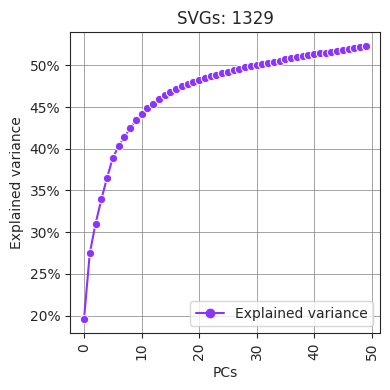

In [6]:
adata.var.index = adata.var['gene_symbols']
adata.var_names = adata.var['gene_symbols']
ch.pca(adata)

ch.plot_explained_variance(adata)
plt.show()

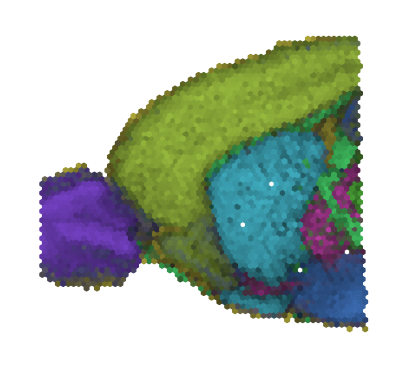

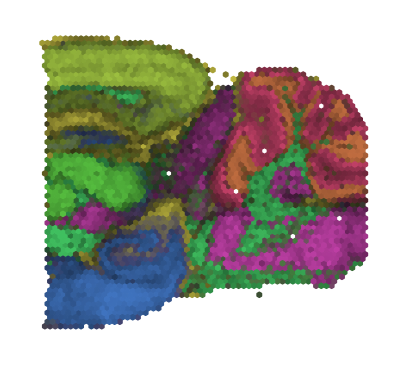

In [7]:
ch.aa(adata, n_pcs=20, n_archetypes=10)

for i in np.unique(adata.obs['sample']):
    ch.plot(adata, dim=10, sample_id=i, rasterized=True)
    plt.show()

We can observe clear continuity between tissue compartments across samples indicating that the integration was successful.

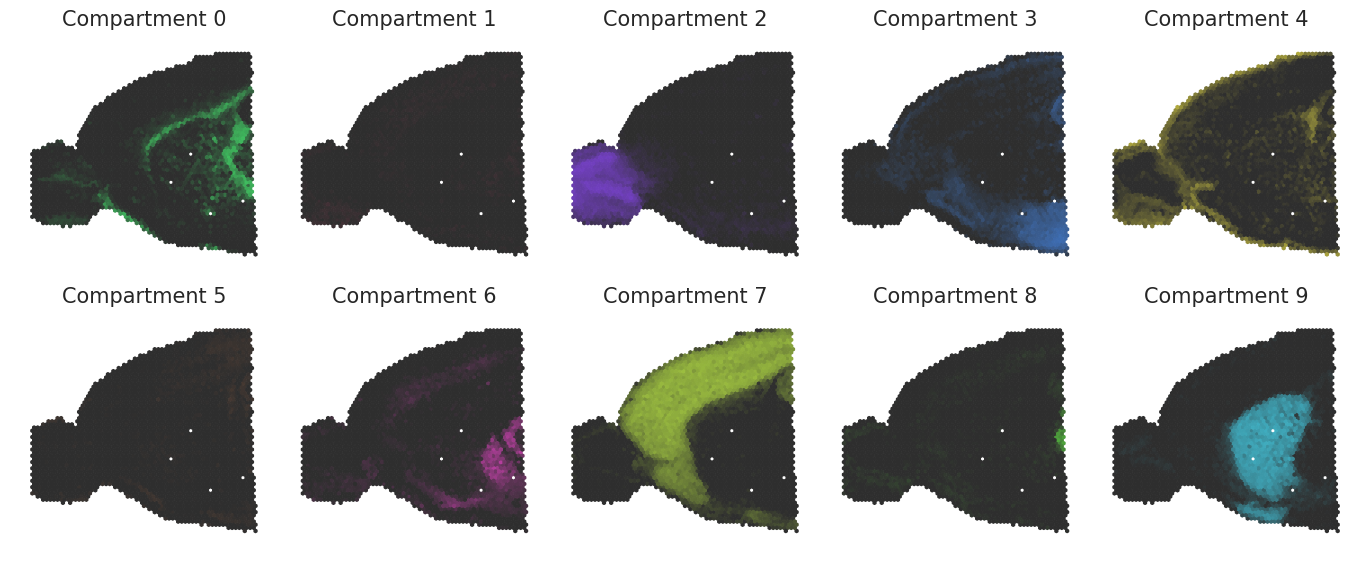

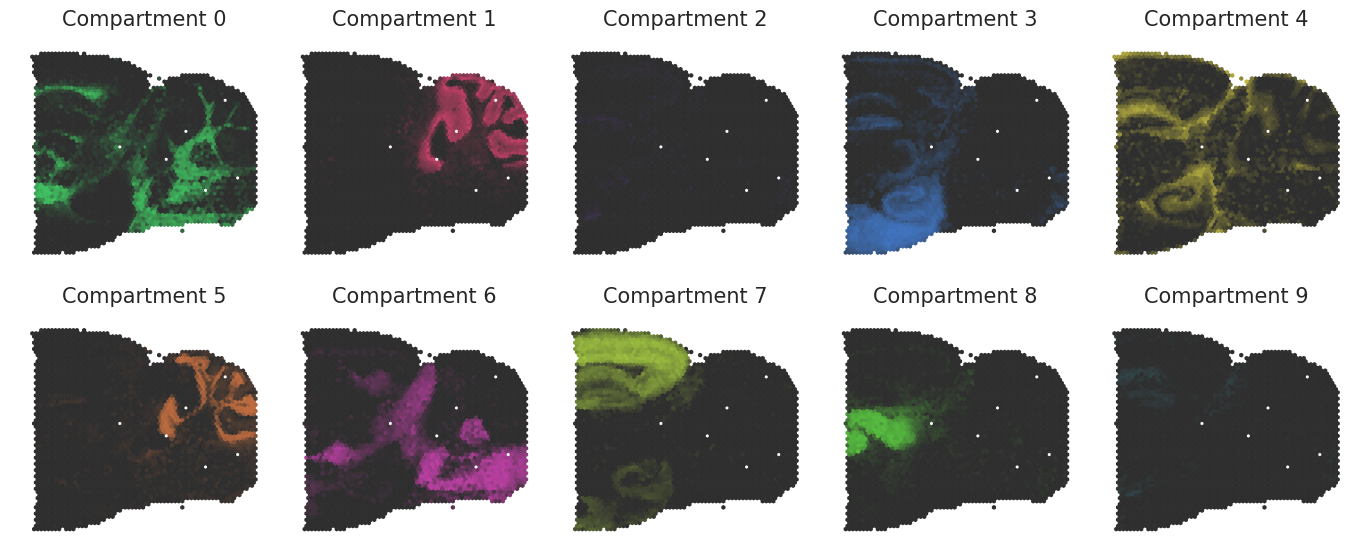

In [8]:
for i in np.unique(adata.obs['sample']):
    ch.plot_compartments(adata, sample_id=i, ncols=5, rasterized=True, title_size=15)
    plt.show()

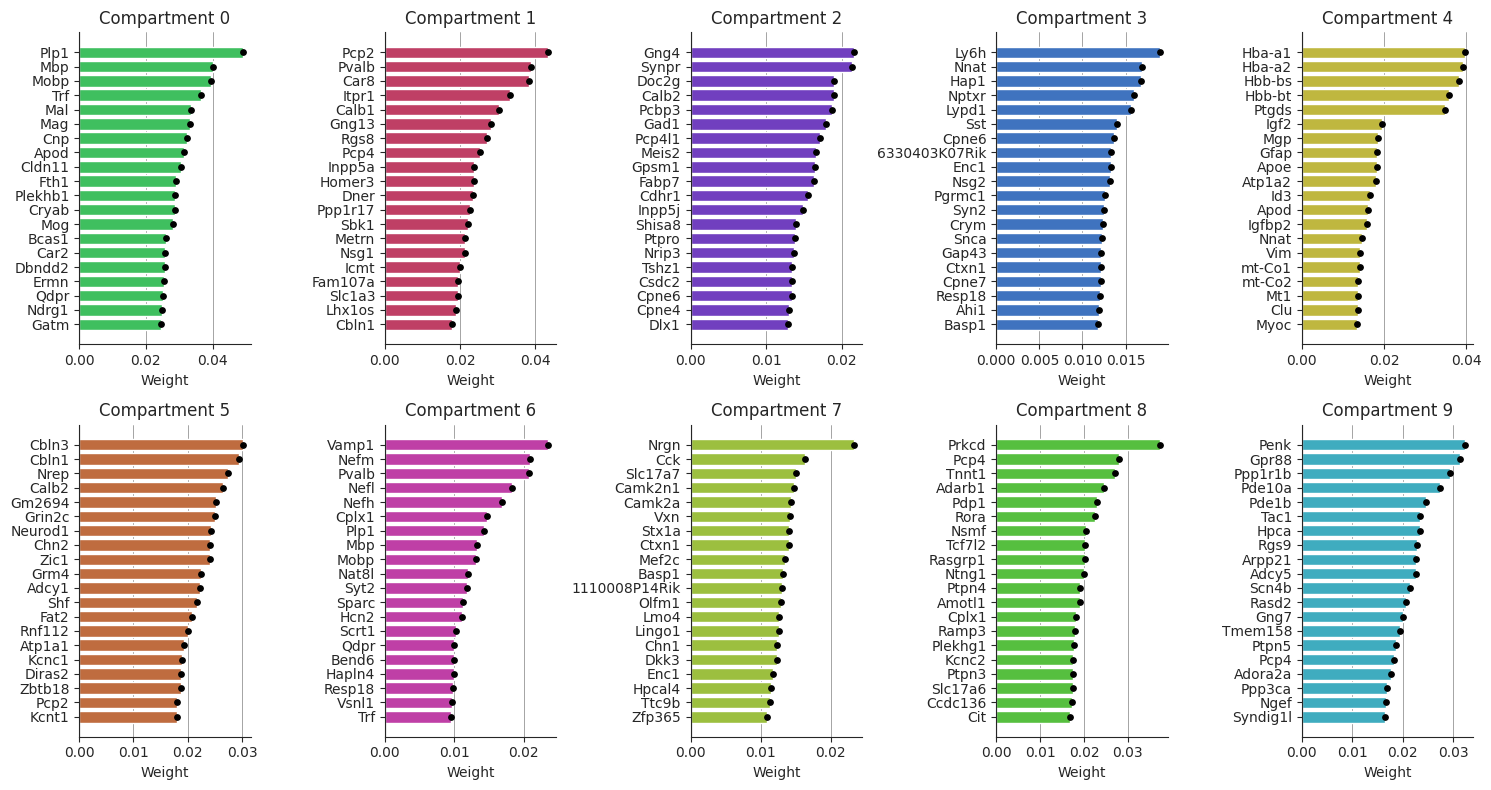

In [9]:
ch.plot_weights(adata, ncols=5)
plt.show()